In [1]:
import sys, os, decimal, json
sys.path.append(os.path.realpath('..'))
import json, time
import pandas as pd
import random
import matplotlib.pyplot as plt
import glob

import matplotlib.pyplot as plt
import numpy as np
import PIL, json
import tensorflow as tf
import socket
import pathlib
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageOps

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.applications import VGG16

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

from TrainingPipelines.ImageClassifier.ModelBuilder import build_and_train

import seaborn as sns
import mplcyberpunk
tf.random.set_seed(42)

plt.style.use("cyberpunk")
plt.rcParams['figure.facecolor'] = '#0d1117'
plt.rcParams['axes.facecolor'] = '#0d1117'
plt.rcParams['savefig.facecolor'] = '#0d1117'

# PLAN
1. Train Boxes
2. transfer in those boxes
3. train location of boxes

In [2]:
config_meta = {'image_resize': [600, 500], 
               'class_location': 'O:\\eve_models\\training_data\\large_box_counter\\large_box_counter_classes.json', 
               'model_location': 'O:\\eve_models\\training_data\\large_box_counter\\large_box_counter_model.h5', 
               'class_names': ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '23', '24', '25', '26', '27', '28', '29', '3', '4', '5', '6', '7', '8', '9']}
box_counter_model = tf.keras.models.load_model(config_meta['model_location'], compile=False)
config = json.load(open(config_meta['class_location']))
config

['1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

In [3]:
box_counter_model.layers

In [4]:
img = Image.open(r"O:\eve_models\training_data\large_box_counter\8\527d8b7b-d4cd-11ed-9db1-2cf05d9fe8eb.png")
train_x = []

img = img.resize(
    (config_meta['image_resize'][1], config_meta['image_resize'][0]),
    # TF trains backwards
    resample=Image.Resampling.NEAREST)

train_x.append(np.array(img))

image_array = train_x[0]

In [5]:
image_array.shape

(600, 500, 3)

In [6]:
prediction = box_counter_model.predict(np.array([image_array]))
prediction

1/1 [==============================] - 2s 2s/step


array([[-30.462742 , -39.840965 , -42.916325 , -35.60908  , -45.459663 ,
        -41.636574 , -58.785175 , -51.846    , -44.268543 , -49.43849  ,
        -48.762955 , -25.781338 , -63.416096 , -64.36718  , -64.275    ,
        -73.49912  , -63.970997 , -82.56597  , -70.85012  , -88.50912  ,
        -73.353294 , -40.09852  , -37.036076 , -31.532862 , -29.25871  ,
        -31.344072 ,  -1.7273793, -29.104116 ]], dtype=float32)

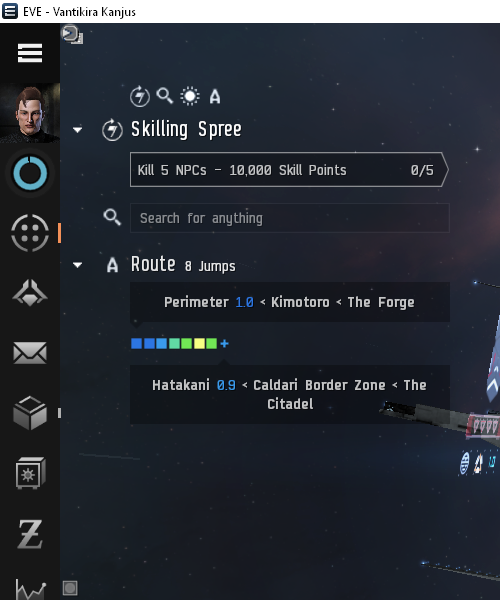

In [7]:
img

In [8]:
config[np.argmax(prediction)]

'8'

In [9]:
conv_model = tf.keras.Model(box_counter_model.layers[0:-4])

In [10]:
layer_outputs = []
for i in range(1, len(box_counter_model.layers)):
    tmp_model = tf.keras.Model(box_counter_model.layers[0].input, box_counter_model.layers[i].output)
    tmp_output = tmp_model.predict(np.array([image_array]))[0]
    layer_outputs.append(tmp_output)

1/1 [==============================] - 0s 49ms/step


In [11]:
layer_outputs[3].shape

(150, 125, 32)

In [13]:
layer_outputs[0][:,:,0:3].shape

(600, 500, 3)

In [26]:
single = layer_outputs[0][:,:,0:3]
single = (single * np.array(1000)).astype(np.uint8)
single.shape

(600, 500, 3)

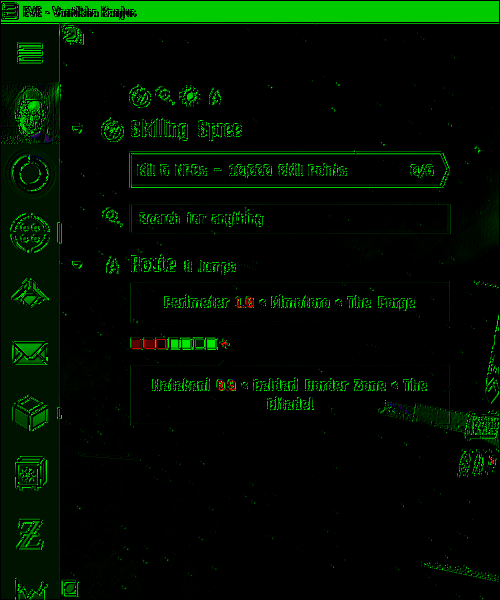

In [27]:
Image.fromarray(single).convert('RGB')

In [28]:
source_model = tf.keras.Model(box_counter_model.layers[0].input, box_counter_model.layers[7].output)
for source_layer in source_model.layers:
    source_model.trainable = False
tmp_output = source_model.predict(np.array([image_array]))[0]
tmp_output

1/1 [==============================] - 0s 41ms/step


array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [ ]:
model = Sequential([
    layers.Input(shape=(img_height, img_width,3)),
    #layers.Rescaling(1. / 255, input_shape=(img_height, img_width,3)),
    source_model,
    layers.Flatten(),
    #layers.Dense(units=128, activation='relu'),
    #layers.Dense(units=64, activation='relu'),
    layers.Dense(units=32, activation="relu"),
    layers.Dense(units=1, activation="sigmoid", name='bounding_box')  
])
